# Homework7_Q1
YangBai 

UFID: 43881346

In [204]:
#Import needed python libraries
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline 
import math 
import textwrap
from sklearn import preprocessing

In [205]:
#Read dataset
f_white = open('WhiteWine_HW7.txt','r')
data_white = f_white.read()
f_red = open('RedWine_HW7.txt','r')
data_red = f_red.read()
f_white.close()
f_red.close()

In [206]:
#Data preprocessing
#Split data
WhiteWine_data = []
RedWine_data = []

#Split between lines
Lines_white = data_white.split('\n')
Lines_red   = data_red.split('\n')

#Split between datas in each line
for Line in Lines_white:
    data_in_line = Line.split()
    WhiteWine_data.append(data_in_line)
    
for Line in Lines_red:
    data_in_line = Line.split()
    RedWine_data.append(data_in_line)

# Remove title
WhiteWine_data = WhiteWine_data[1:]
RedWine_data   = RedWine_data[1:]

#Remove spacelines
WhiteWine_data = list(filter(None, WhiteWine_data))
RedWine_data   = list(filter(None, RedWine_data))

#Transfer datatype as float point
WhiteWine_data = [list(map(float, x)) for x in WhiteWine_data]
RedWine_data   = [list(map(float, x)) for x in RedWine_data]

# Convert to numpy array
entire_WhiteWine_data = np.array(WhiteWine_data)
entire_RedWine_data   = np.array(RedWine_data)
entire_global = np.concatenate((entire_WhiteWine_data, entire_RedWine_data), axis=0)

In [207]:
#New notation for original dataset
X_0 = entire_WhiteWine_data
X_1 = entire_RedWine_data
S = X_0[:,0].size #Number of rows in the dataset

In [208]:
def FisherDiscriminantRatio(X_0, X_1):
    #setting regularization parameter
    lamb = 0.3
    
    Mu_0 = X_0.mean(axis = 0)
    Mu_1 = X_1.mean(axis = 0)
    N_0 = X_0 - Mu_0
    N_1 = X_1 - Mu_1

    #Compute the covaiance of training_data
    Cov_0 = (N_0.transpose()@X_0)/(N_0.shape[0])
    Cov_1 = (N_1.transpose()@X_1)/(N_1.shape[0])
    
    #Compute the global covariance of the two classes' dataset
    X_global   = np.concatenate((X_0, X_1), axis=0)
    Mu_global = X_global.mean(axis = 0)
    N_global = X_global - Mu_global
    Cov_global = (N_global.transpose()@N_global)/(N_global.shape[0])
    
    #Compute the Fisher Discriminant Ratio
    Sm      = Cov_global
    if X_0.size == S: #When there is only one colnmn in the updated dataset, the Cov_0 and Cov_1 are two real numbers
        Sw      = Cov_0 + Cov_1
        temp    = 1/Sw
        F_ratio = Sm * temp
    else: #When there are more than one colnmn in the updated dataset, the Cov_0 and Cov_1 are two square matrices
        Sw      = Cov_0 + Cov_1 + lamb * np.identity(X_0.shape[1])
        temp    = np.linalg.inv(Sw)
        F_ratio = np.trace(Sm @ temp)
    
    return F_ratio

# Forward Feature Selection(FFS)

In [209]:
def FFS(X_0, X_1, New_0, New_1):
    F_max = 0
    i_max = 0
    
    #Traverse the updated dataset to find the best feature
    for i in range(0, X_0.shape[1]):
        #Assign the new datasets to temporary matrices A_0 and A_1
        A_0 = New_0
        A_1 = New_1

        #Concatenate ith column of updated dataset to A_0 and A_1
        A_0 = np.concatenate((A_0, X_0[:,i:i+1]), axis=1)
        A_1 = np.concatenate((A_1, X_1[:,i:i+1]), axis=1)
        
        #Delete the first column of A_0 and A_1 because it was initialized as zeros
        A_0 = np.delete(A_0, 0, 1)
        A_1 = np.delete(A_1, 0, 1)

        F = FisherDiscriminantRatio(A_0, A_1)

        #Find the feature of the updated dataset that affect performence the most
        if F > F_max:
            F_max = F
            i_max = i
                
    return F_max, i_max

In [210]:
#Initialize parameters
New_0 = np.zeros((X_0.shape[0],1))
New_1 = np.zeros((X_1.shape[0],1))
Fisher_Ratio = [3] #This number is used to adjust the final plot

while X_0.size >= S:
    F,i = FFS(X_0, X_1, New_0, New_1)
    Fisher_Ratio.append(F)
    #Add the selected feature to the new datasets.
    New_0 = np.concatenate((New_0, X_0[:,i:i+1]), axis=1)
    New_1 = np.concatenate((New_1, X_1[:,i:i+1]), axis=1)
    #Update the datasets by removing the selected feature
    X_0 = np.delete(X_0, i, 1)
    X_1 = np.delete(X_1, i, 1)
    #N_global = np.delete(N_global, i, 1)

In [211]:
#Records the Fisher Ratios 
NewFeatureSet_0 = np.delete(New_0, 0, 1)
NewFeatureSet_1 = np.delete(New_1, 0, 1)

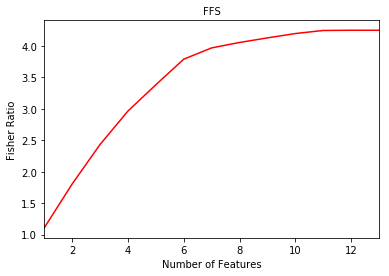

In [212]:
plt.xlim(1,13)
p1 = plt.plot(Fisher_Ratio, 'r')
#add legend and title
plt.rcParams["axes.titlesize"] = 10
plt.title('FFS');
plt.ylabel('Fisher Ratio') #label x and y axes
plt.xlabel('Number of Features')

# Backward Feature Selection(BFS)

In [213]:
def BFS(X_0, X_1): 
    F1 = FisherDiscriminantRatio(X_0, X_1)
    D_min = 100
    i_max = 0
    
    #Traverse the updated dataset to find the best feature
    for i in range(0, X_0.shape[1]):  
        #Assign the updated datasets to temporary matrices A_0 and A_1
        A_0 = X_0
        A_1 = X_1
        #Delet the ith column from A_0 and A_1
        A_0 = np.delete(A_0, i, 1)
        A_1 = np.delete(A_1, i, 1)
        F2 = FisherDiscriminantRatio(A_0, A_1,)
        D = F1 - F2
        #Find the feature of the updated dataset that affects the performence the most
        if D < D_min:
            D_min = D
            i_min = i
    return F1, i_min

In [214]:
X_0 = entire_WhiteWine_data
X_1 = entire_RedWine_data
S = X_0[:,0].size #Number of rows in the dataset

new_0 = np.zeros((X_0.shape[0],1))
new_1 = np.zeros((X_1.shape[0],1))
Fisher_Ratio = []

while X_0.size >= S:
    F,i = BFS(X_0, X_1)
    #Records the Fisher Ratios after each optimize step
    Fisher_Ratio.append(F)
    #Constuct the newdataset by adding the seleted features sequentially
    new_0 = np.concatenate((new_0, X_0[:,i:i+1]), axis=1)
    new_1 = np.concatenate((new_1, X_1[:,i:i+1]), axis=1)
    #Up date the dataset by delet the selected features
    X_0 = np.delete(X_0, i, 1)
    X_1 = np.delete(X_1, i, 1)

In [215]:
#Delete the first column from the new datasets because they were initialized as zeros
newFeatureSet_0 = np.delete(new_0, 0, 1)
newFeatureSet_1 = np.delete(new_1, 0, 1)
#Flip the nue datasets
newFeatureSet_0 = np.flip(newFeatureSet_0, 1)
newFeatureSet_1 = np.flip(newFeatureSet_1, 1)

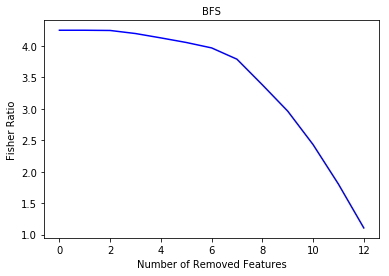

In [216]:
p2 = plt.plot(Fisher_Ratio, 'b')
#add legend and title
plt.rcParams["axes.titlesize"] = 10
plt.title('BFS');
plt.ylabel('Fisher Ratio') #label x and y axes
plt.xlabel('Number of Removed Features')

In [217]:
Difference = newFeatureSet_0 - NewFeatureSet_0
print(sum(sum(Difference)))

0.0


# Bayes Classifier

In [218]:
def Discriminant_Function(Data, Prior, Mean, Covariance):
    n = Data.shape[0]
    discriminant = []
    temp2 = - math.log(2 * math.pi) * Mean.size / 2
    temp3 = - math.log(np.linalg.det(Covariance)) / 2
    temp4 = math.log(Prior)
    for i in range(0, n):
        x = Data[i] - Mean
        temp1 = - (np.transpose(x) @ np.linalg.inv(Covariance) @ x) / 2
        g = temp1 + temp2 + temp3 + temp4
        discriminant.append(g)
    return discriminant

In [219]:
def Evaluation(True_Class, False_Class, n):
    
    true = 0
    false = 0
    
    for i in range(0, len(True_Class)):
        if True_Class[i] > False_Class[i]:
            true = true + 1
        else:
            false = false + 1
    
    # Compute the rate of true and false
    rate_true = true/n
    rate_false = false/n

    return rate_true, rate_false

In [220]:
#Find the best number of features that can make the bayes classifier get best performence
CorrectRate_max = 0
correct_rate = [0.995]#This number is used to adjust the final plot
for i in range(1, 14):
    X_0 = newFeatureSet_0[:, 0:i]
    X_1 = newFeatureSet_1[:, 0:i]
    N = X_0.shape[0] + X_1.shape[0]

    #Compute the Prior
    P_0 = X_0.shape[0] / N
    P_1 = X_1.shape[0] / N
    
    #Compute the mean of data
    Mu_0 = X_0.mean(axis = 0)
    Mu_1 = X_1.mean(axis = 0)
    
    #Normalize training data
    N_0 = X_0 - Mu_0
    N_1 = X_1 - Mu_1
    
    
    #Compute the covaiance of data
    Cov_0 = (N_0.transpose()@N_0)/(N_0.shape[0])
    Cov_1 = (N_1.transpose()@N_1)/(N_1.shape[0])
    
    #Compute Discriminant_Function
    g0_J0 = Discriminant_Function(X_0, P_0, Mu_0, Cov_0)
    g1_J0 = Discriminant_Function(X_0, P_1, Mu_1, Cov_1)

    g0_J1 = Discriminant_Function(X_1, P_0, Mu_0, Cov_0)
    g1_J1 = Discriminant_Function(X_1, P_1, Mu_1, Cov_1)
    
    n = X_0.shape[0] + X_1.shape[0]

    rate_true_0, rate_false_0 = Evaluation(g0_J0, g1_J0, n)
    rate_true_1, rate_false_1 = Evaluation(g1_J1, g0_J1, n)
    
    CorrectRate = rate_true_0 + rate_true_1
    correct_rate.append(CorrectRate)   
    
    if CorrectRate > CorrectRate_max:
        CorrectRate_max = CorrectRate
        i_max = i

print(i_max)
print(CorrectRate_max)

13
0.9855317839002616


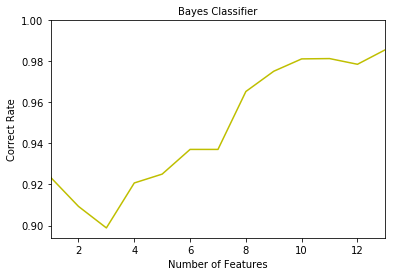

In [221]:
correct_rate = np.array(correct_rate)
plt.xlim(1,13)
p3 = plt.plot(correct_rate ,'y')
#add legend and title
plt.rcParams["axes.titlesize"] = 10
plt.title('Bayes Classifier');
plt.ylabel('Correct Rate') #label x and y axes
plt.xlabel('Number of Features')